### Student Number : 2
#### Alexandre Lemonnier (alexandre.lemonnier) (23077)
#### Victor Simonin (victor.simonin) (23093)

First, let's import our useful libraries

In [268]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, isnull, mean, abs, max, avg, lag
from pyspark.sql.window import Window
from datetime import timedelta
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np


In [4]:
spark_application_name = "Projet_LAVS"
spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())

22/05/18 11:42:11 WARN Utils: Your hostname, leme-thinkpad resolves to a loopback address: 127.0.1.1; using 10.29.118.66 instead (on interface wlp4s0)
22/05/18 11:42:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/18 11:42:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Here we define the structure of the schema and its columns with their relative types

In [5]:
columns = [StructField("Date",TimestampType()), StructField("High",FloatType()), StructField("Low",FloatType()), StructField("Open",FloatType()), StructField("Close",FloatType()), StructField("Volume",FloatType()), StructField("Adj Close",FloatType()), StructField("company_name",StringType())]
schema = StructType(columns)

def read_data(path):
    return spark.read.schema(schema).csv(path, header=True, sep=',')

In [6]:
amazon = read_data('data/AMAZON.csv')
apple = read_data('data/APPLE.csv')
facebook = read_data('data/FACEBOOK.csv')
google = read_data('data/GOOGLE.csv')
microsoft = read_data('data/MICROSOFT.csv')
tesla = read_data('data/TESLA.csv')
zoom = read_data('data/ZOOM.csv')
datasets = [amazon, apple, facebook, google, microsoft, tesla, zoom]

## Exploration of the datasets (part 1)

Now let's do the exploration of our datasets :

In [7]:
# Show the first and last 40 rows of each stock price
def head_tail_40(dataset):
    print("Head/tail 40 rows of the dataset", dataset.head().company_name)
    print("\nThe 40 first elements : ")
    spark.createDataFrame(dataset.head(40)).show(40)
        
    print("\nThe 40 last elements : ")
    spark.createDataFrame(dataset.tail(40)).show(40)

In [8]:
# Example
head_tail_40(amazon)

Head/tail 40 rows of the dataset AMAZON

The 40 first elements : 


+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+
|               Date|             High|              Low|             Open|            Close|   Volume|        Adj Close|company_name|
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+
|2017-01-03 00:00:00| 758.760009765625|747.7000122070312|757.9199829101562|753.6699829101562|3521100.0|753.6699829101562|      AMAZON|
|2017-01-04 00:00:00|759.6799926757812|754.2000122070312|758.3900146484375|757.1799926757812|2510500.0|757.1799926757812|      AMAZON|
|2017-01-05 00:00:00|782.4000244140625| 760.260009765625|761.5499877929688|780.4500122070312|5830100.0|780.4500122070312|      AMAZON|
|2017-01-06 00:00:00|799.4400024414062|  778.47998046875|782.3599853515625| 795.989990234375|5986200.0| 795.989990234375|      AMAZON|
|2017-01-09 00:00:00|  801.77001953125|  791.7700195312

In [9]:
def get_number_of_observation(dataset):
    print(f"The total number of observations of {dataset.head().company_name} dataset:", dataset.count())

In [10]:
# Example
get_number_of_observation(amazon)

The total number of observations of AMAZON dataset: 987


In [11]:
def get_time_delta(dataset):
    print("The first date is", dataset.head().Date)
    print("The second date is", dataset.head(2)[1].Date)
    delta = dataset.head(2)[1].Date - dataset.head().Date 
    print(f"So we deduce the timedelta for {dataset.head().company_name} dataset is {delta}")
    

In [12]:
# Example
get_time_delta(amazon)

The first date is 2017-01-03 00:00:00
The second date is 2017-01-04 00:00:00
So we deduce the timedelta for AMAZON dataset is 1 day, 0:00:00


In [13]:
def get_statistics(dataset):
    print(f"Some statistics for {dataset.head().company_name}:")
    dataset.summary().show()
    print("Missing values :")
    dataset.select([count(when(isnull(c), c)).alias(c) for c in dataset.columns]).show()

In [14]:
# Example
get_statistics(amazon)

Some statistics for AMAZON:


+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------+
|summary|              High|               Low|             Open|             Close|           Volume|         Adj Close|company_name|
+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------+
|  count|               987|               987|              987|               987|              987|               987|         987|
|   mean|1762.0071216958152|1722.1011452099956|1743.433881363487|1742.9566644206718| 4509728.05775076|1742.9566644206718|        null|
| stddev| 667.2385315752688| 644.7988093382758|657.1153070927137| 655.9576061129322|2179817.628631287| 655.9576061129322|        null|
|    min|            758.76|             747.7|           757.92|            753.67|         881300.0|            753.67|      AMAZON|
|    25%|            1191.0|            1176.0|        

In [76]:
# Correlation matrix plot function
def plot_corr_matrix(correlations,attr,fig_no):
    fig = plt.figure(figsize=(15, 12))
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

In [77]:
def get_values_correlation(dataset):
    print(f"Correlation matrix for {dataset.head().company_name} dataset:")
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], outputCol=vector_col)
    df_vector = assembler.transform(dataset).select(vector_col)

    # get correlation matrix
    matrix = Correlation.corr(df_vector, vector_col)
    cor_np = matrix.collect()[0][matrix.columns[0]].toArray()
    plot_corr_matrix(cor_np, ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], 234)

Correlation matrix for AMAZON dataset:


/tmp/ipykernel_190375/465303234.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_190375/465303234.py:7: UserWarning:

FixedFormatter should only be used together with FixedLocator



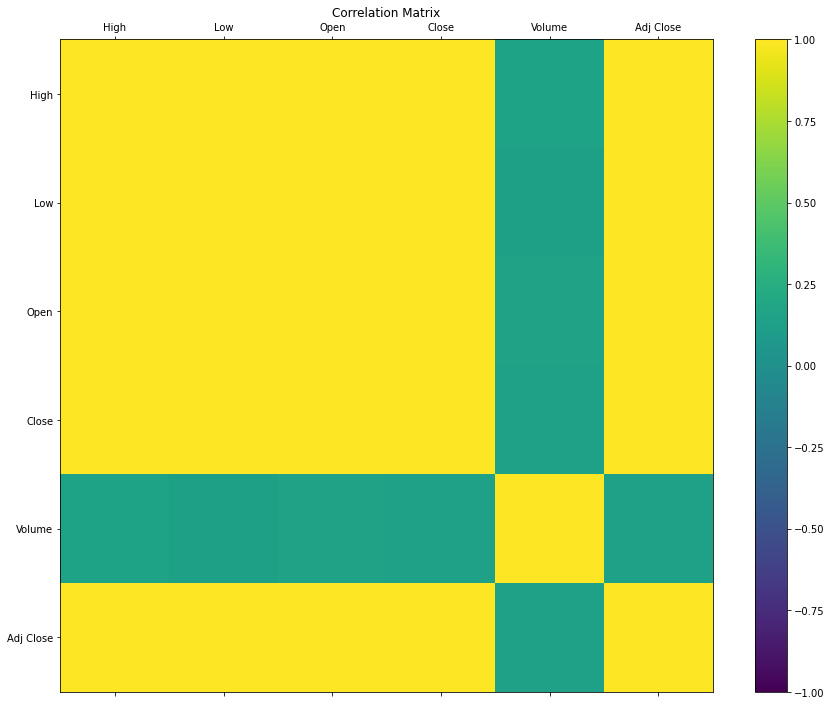

In [78]:
# Example
get_values_correlation(amazon)

Here is our global function to use for our datasets exploration

In [18]:
def exploration(dataset):
    head_tail_40(dataset)
    
    get_number_of_observation(dataset)
   
    get_time_delta(dataset)
    
    get_statistics(dataset)
    
    get_values_correlation(dataset)

Head/tail 40 rows of the dataset AMAZON

The 40 first elements : 
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+
|               Date|             High|              Low|             Open|            Close|   Volume|        Adj Close|company_name|
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+
|2017-01-03 00:00:00| 758.760009765625|747.7000122070312|757.9199829101562|753.6699829101562|3521100.0|753.6699829101562|      AMAZON|
|2017-01-04 00:00:00|759.6799926757812|754.2000122070312|758.3900146484375|757.1799926757812|2510500.0|757.1799926757812|      AMAZON|
|2017-01-05 00:00:00|782.4000244140625| 760.260009765625|761.5499877929688|780.4500122070312|5830100.0|780.4500122070312|      AMAZON|
|2017-01-06 00:00:00|799.4400024414062|  778.47998046875|782.3599853515625| 795.989990234375|5986200.0| 795.989990234375|   

/tmp/ipykernel_190375/361286314.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
/tmp/ipykernel_190375/361286314.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


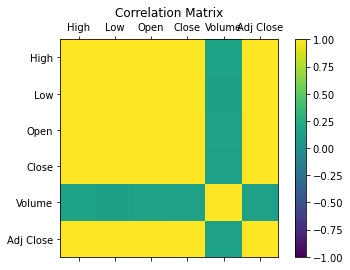

In [19]:
# Example
exploration(amazon)

## Exploration of the datasets (part 2)

Computation of the average of the opening and closing prices for each stock price and for
different time periods (week, month, year)

Usage:
* `type` can be set to *week*, *month* or *year* to change the scale used for the average
* `beginDate` can be set to any date present in the dataset where the average computation will begin

In [20]:
def average_opening_closing(dataset, type=None, beginDate=None):
    if not beginDate:
        beginDate = dataset.head().Date
    if type == "week":
        dd = dataset.select('Open', 'Close').filter(dataset.Date < beginDate + timedelta(weeks=1))
    elif type == "month":
        dd = dataset.select('Open', 'Close').filter(dataset.Date < beginDate + timedelta(weeks=4))
    elif type == "year":
        dd = dataset.select('Open', 'Close').filter(dataset.Date < beginDate + timedelta(weeks=52))
    else:
        dd = dataset.select('Open', 'Close')
    dd = dd.withColumn('Result', abs(dataset['Close'] - dataset['Open']))
    dd.select((mean('Result'))).show()

In [21]:
# Example
average_opening_closing(amazon, type="year", beginDate=amazon.head(50)[-1].Date)

+-----------------+
|      avg(Result)|
+-----------------+
|9.063970743815105|
+-----------------+



To study how the stock prices change day to day and month to month, we dediced
to represent *Open*, *High*, *Low* and *Close* column with a candlestick chart.

In [22]:
import plotly.graph_objects as go

def plot_prices_evolution(dataset):
    df = dataset.toPandas()

    fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

    fig.show()

In [23]:
# Example
plot_prices_evolution(amazon)

Based on the opening and closing price, we compute the daily return of a stock.

In [24]:
def compute_daily_return(dataset):
    return dataset.withColumn('daily_return', dataset['Close'] - dataset['Open'])

In [25]:
# Example
compute_daily_return(amazon).show()

+-------------------+------+------+------+------+---------+---------+------------+------------+
|               Date|  High|   Low|  Open| Close|   Volume|Adj Close|company_name|daily_return|
+-------------------+------+------+------+------+---------+---------+------------+------------+
|2017-01-03 00:00:00|758.76| 747.7|757.92|753.67|3521100.0|   753.67|      AMAZON|       -4.25|
|2017-01-04 00:00:00|759.68| 754.2|758.39|757.18|2510500.0|   757.18|      AMAZON|   -1.210022|
|2017-01-05 00:00:00| 782.4|760.26|761.55|780.45|5830100.0|   780.45|      AMAZON|   18.900024|
|2017-01-06 00:00:00|799.44|778.48|782.36|795.99|5986200.0|   795.99|      AMAZON|   13.630005|
|2017-01-09 00:00:00|801.77|791.77| 798.0|796.92|3446100.0|   796.92|      AMAZON|  -1.0800171|
|2017-01-10 00:00:00| 798.0|789.54| 796.6| 795.9|2558400.0|    795.9|      AMAZON|  -0.6999512|
|2017-01-11 00:00:00| 799.5|789.51|793.66|799.02|2992800.0|   799.02|      AMAZON|   5.3600464|
|2017-01-12 00:00:00|814.13| 799.5|800.3

Let's get the stocks with the highest **daily return** between our datasets:

In [26]:
def get_max_daily_return(datasets):
    max_daily_return = []
    for dataset in datasets:
        name = dataset.head().company_name
        dd = compute_daily_return(dataset)
        max_daily_return.append((name, dd.select(max("daily_return")).collect()))
    return max_daily_return

In [27]:
max_daily_return = get_max_daily_return(datasets)
for name, max_dr in max_daily_return:
    print(f"{name} max daily return : {max_dr[0][0]}")

AMAZON max daily return : 196.64013671875
APPLE max daily return : 5.540000915527344
FACEBOOK max daily return : 19.910003662109375
GOOGLE max daily return : 61.8299560546875
MICROSOFT max daily return : 11.330001831054688
TESLA max daily return : 53.71002197265625
ZOOM max daily return : 34.470001220703125


Computation of the average of the daily_return of a stock for
different time periods (week, month, year)

Usage:
* `type` can be set to *week*, *month* or *year* to change the scale used for the average
* `beginDate` can be set to any date present in the dataset where the average computation will begin

In [28]:
def average_daily_return(dataset, type=None, beginDate=None):
    dd = compute_daily_return(dataset)
    if not beginDate:
        beginDate = dd.head().Date
    if type == "week":
        dd = dd.select('daily_return').filter(dd.Date < beginDate + timedelta(weeks=1))
    elif type == "month":
        dd = dd.select('daily_return').filter(dd.Date < beginDate + timedelta(weeks=4))
    elif type == "year":
        dd = dd.select('daily_return').filter(dd.Date < beginDate + timedelta(weeks=52))
    else:
        dd = dd.select('daily_return')
    dd.select((mean('daily_return'))).show()

In [29]:
# Example
average_daily_return(amazon, type="year")

+--------------------+
|   avg(daily_return)|
+--------------------+
|-0.10860731877178785|
+--------------------+



## Moving average

The moving average is calculated by adding a stock's prices over a certain
period and dividing the sum by the total number of periods. 

In [30]:
def moving_average(dataset, column_name, nb_points):
    days = lambda i: i * 86400
    w = (Window.orderBy(col("date").cast('long')).rangeBetween(-days(nb_points), 0))
    return dataset.withColumn('moving_average', avg(column_name).over(w))

In [31]:
moving_average(amazon, 'Open', 5).show()

22/05/18 11:42:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/18 11:42:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/18 11:42:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+------+------+------+------+---------+---------+------------+-----------------+
|               Date|  High|   Low|  Open| Close|   Volume|Adj Close|company_name|   moving_average|
+-------------------+------+------+------+------+---------+---------+------------+-----------------+
|2017-01-03 00:00:00|758.76| 747.7|757.92|753.67|3521100.0|   753.67|      AMAZON|757.9199829101562|
|2017-01-04 00:00:00|759.68| 754.2|758.39|757.18|2510500.0|   757.18|      AMAZON|758.1549987792969|
|2017-01-05 00:00:00| 782.4|760.26|761.55|780.45|5830100.0|   780.45|      AMAZON|759.2866617838541|
|2017-01-06 00:00:00|799.44|778.48|782.36|795.99|5986200.0|   795.99|      AMAZON|765.0549926757812|
|2017-01-09 00:00:00|801.77|791.77| 798.0|796.92|3446100.0|   796.92|      AMAZON|775.0749969482422|
|2017-01-10 00:00:00| 798.0|789.54| 796.6| 795.9|2558400.0|    795.9|      AMAZON|784.6274871826172|
|2017-01-11 00:00:00| 799.5|789.51|793.66|799.02|2992800.0|   799.02|      AMAZON|792.65498

## Correlation between datasets

In [44]:
def correlation_two_datasets(stock1, stock2):
    stock_renamed = stock2.select([col(c).alias(c+str(2)) for c in stock2.columns])
    merged = stock1.join(stock_renamed, stock1.Date == stock_renamed.Date2, "left_outer")
    print(f"Correlation between {stock1.head().company_name} and {stock2.head().company_name}")
    print(f"Correlation between Open column: ", merged.corr("Open", "Open2"))
    print(f"Correlation between Close column: ", merged.corr("Close", "Close2"))
    print(f"Correlation between High column: ", merged.corr("High", "High2"))
    print(f"Correlation between Low column: ", merged.corr("Low", "Low2"))
    print(f"Correlation between Volume column: ", merged.corr("Volume", "Volume2"))

In [45]:
correlation_two_datasets(amazon, apple)

Correlation between AMAZON and APPLE
Correlation between Open column:  0.929432373427345
Correlation between Close column:  0.9292860084204524
Correlation between High column:  0.9297874259390847
Correlation between Low column:  0.9294547100635051
Correlation between Volume column:  0.5340081172190727


In [50]:
def get_datasets_merged(datasets):
    suffix = 0
    res = datasets[0].select("*")
    res = res.select([col(c).alias(c+str(suffix)) for c in res.columns])
    suffix += 1
    for i in range(len(datasets) -1):
        stock_renamed =  datasets[i+1].select([col(c).alias(c+str(suffix)) for c in datasets[i+1].columns])
        res = res.join(stock_renamed, res.Date0 == stock_renamed["Date" + str(suffix)], how="left_outer")
        suffix += 1
    return res

In [51]:
# Example
get_datasets_merged(datasets).show()

22/05/18 11:47:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+------+------+------+------+---------+----------+-------------+-------------------+-------+-------+-------+-------+----------+----------+-------------+-------------------+------+------+------+------+---------+----------+-------------+-------------------+-------+-------+------+-------+---------+----------+-------------+-------------------+-----+-----+-----+------+---------+----------+-------------+-------------------+------+------+------+------+---------+----------+-------------+-----+-----+----+-----+------+-------+----------+-------------+
|              Date0| High0|  Low0| Open0|Close0|  Volume0|Adj Close0|company_name0|              Date1|  High1|   Low1|  Open1| Close1|   Volume1|Adj Close1|company_name1|              Date2| High2|  Low2| Open2|Close2|  Volume2|Adj Close2|company_name2|              Date3|  High3|   Low3| Open3| Close3|  Volume3|Adj Close3|company_name3|              Date4|High4| Low4|Open4|Close4|  Volume4|Adj Close4|company_name4|           

In [246]:
# Correlation matrix plot function
def plot_corr_matrix_column(fig, ax, correlations, attr, column_name):
    mat = ax.matshow(correlations, vmax=1, vmin=-1)
    ax.set_xticks(range(len(attr)), attr, rotation=45)
    ax.set_yticks(range(len(attr)), attr )
    ax.set_title(f"{column_name}");
    return mat

In [251]:
def datasets_correlation(datasets):
    column_names = [column[0] for column in datasets[0].dtypes if column[1] == "float"]
    merged = get_datasets_merged(datasets)
    matrix = np.zeros(shape=(len(datasets), len(datasets)))
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("Correlation Matrix", fontsize=20)
    for k, ax in enumerate(axes.flat):
        for i in range(len(datasets)):
            for j in range(len(datasets)):
                matrix[i][j] = merged.corr(column_names[k] + str(i), column_names[k] + str(j))
        mat = plot_corr_matrix_column(fig, ax, matrix, [dataset.head().company_name for dataset in datasets], column_names[k])
    plt.subplots_adjust(left=None,
                    bottom=None, 
                    right=None, 
                    top=None, 
                    wspace=0.8, 
                    hspace=0.2)
    fig.colorbar(mat, ax=axes)

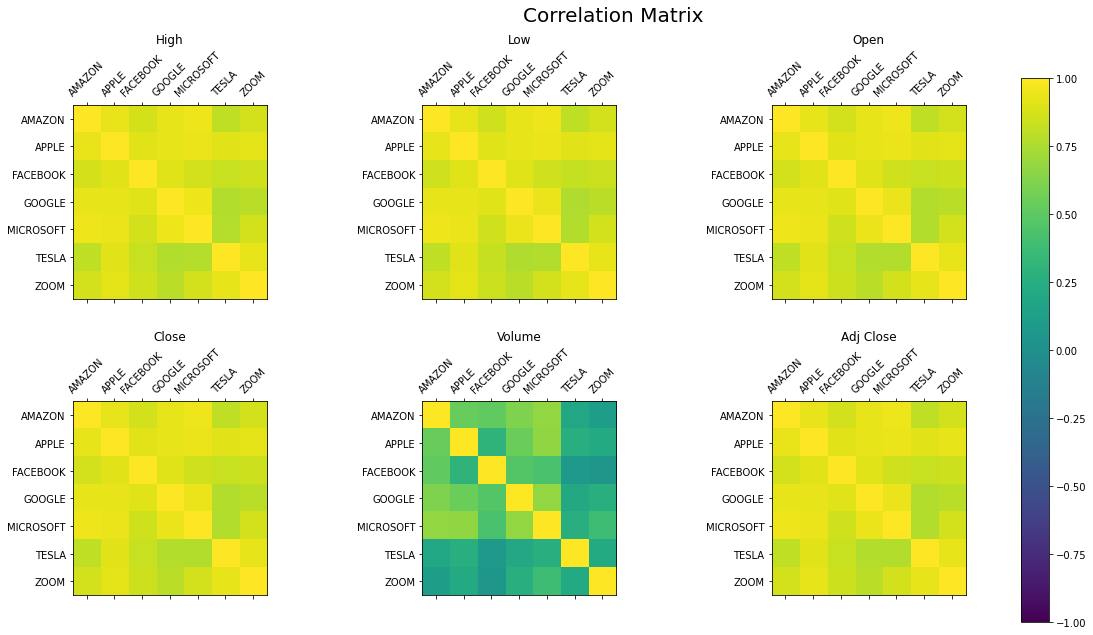

In [252]:
datasets_correlation(datasets)

In [275]:
def compute_return_rate(dataset, nb_days):
    days = lambda i: i * 86400
    w = (Window.orderBy(col("date").cast('long')).rangeBetween(-days(nb_days), 0))
    return dataset.withColumn('return_rate', lag(dataset.Close).over(w))

In [276]:
def get_return_rate(dataset, type=None, beginDate=None):
    if not beginDate:
        beginDate = dataset.head().Date
    if type == "week":
        dd = compute_return_rate(dataset, 7)
    elif type == "month":
        dd = compute_return_rate(dataset, 30)
    elif type == "year":
        dd = compute_return_rate(dataset, 365)
    else:
        dd = compute_return_rate(dataset, 7)
    dd.show()

In [277]:
get_return_rate(amazon, 'week')

AnalysisException: Cannot specify window frame for lag function